### 1. Recommendation System

Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
from random import randint
from collections import defaultdict
from tqdm import tqdm
import re
import math



Build dataframe from csv file

In [11]:
moviesDF = pd.read_csv(r"C:\Users\Elias Antoun\Documents\ADM_HW4_Group3\vodclickstream_uk_movies_03.csv")

# misc pre-handling optimization
moviesDF['datetime'] = pd.to_datetime(moviesDF['datetime'])

moviesDF.head(10)

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287
5,58778,2017-01-01 19:21:37,0.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,c5bf4f3f57
6,58779,2017-01-01 19:43:06,4903.0,The Water Diviner,"Drama, History, War",2014-12-26,7165c2fc94,8e1be40e32
7,58780,2017-01-01 19:44:38,0.0,Angel of Christmas,"Comedy, Romance",2015-11-29,b2f02f2689,892a51dee1
8,58781,2017-01-01 19:46:24,3845.0,Ratter,"Drama, Horror, Thriller",2016-02-12,c39aae36c3,cff8ea652a
9,58782,2017-01-01 20:27:04,0.0,The Book of Life,"Animation, Adventure, Comedy, Family, Fantasy,...",2014-10-17,97183b9136,bf53608c70


**1.1** Title and Genre of top movies that the user _clicked on_

In [3]:
u_m = ['user_id', 'movie_id']

# Break process into chunks, otherwise takes 15+ minutes to run
chunk_size = 10000

# Initialize empty "result" dataframe with columns
top_movies = pd.DataFrame(columns=['user_id', 'title', 'genres', 'click_count', 'movie_id'])

for chunk_start in range(0, len(moviesDF), chunk_size):
    chunk_end = min(chunk_start + chunk_size, len(moviesDF)) 
    chunk = moviesDF.iloc[chunk_start:chunk_end]   # to delimit chunk

    # Group by 'user_id', 'movie_id', and count the clicks for the chunk
    u_m_c = chunk.groupby(u_m).size().reset_index(name='click_count')

    # Use nlargest to get the top 10 movies for each user in the chunk
    top_mov_user = (
        u_m_c.groupby('user_id', group_keys=False)
        .apply(lambda group: group.nlargest(10, 'click_count'))
        .reset_index(drop=True)
    )

    # Merge with original dataframe to get title and genre
    result_chunk = pd.merge(top_mov_user, chunk[['movie_id', 'title', 'genres', 'datetime']], on='movie_id', how='left')

    # Identify and aggregate genuine multiple clicks based on datetime
    result_chunk['click_count'] = result_chunk.groupby(['user_id', 'movie_id', 'title', 'genres'])['click_count'].transform('sum')

    # Drop duplicate rows
    result_chunk = result_chunk.drop_duplicates(subset=['user_id', 'movie_id', 'title', 'genres', 'click_count'])

    # Append chunk result to final result
    top_movies = pd.concat([top_movies, result_chunk], ignore_index=True)



In [4]:
top_movies.head(10)

,user_id,title,genres,click_count,movie_id,datetime
0,0005d9a8f4,Joe and Caspar Hit the Road,"Documentary, Adventure, Comedy",27,416464eaad,2017-01-01 11:05:46
1,001991be8a,Star Trek: First Contact,"Action, Adventure, Drama, Sci-Fi, Thriller",8,dfd60c5a87,2017-01-06 15:27:56
2,0029f6bb1e,Jackass Presents: Bad Grandpa,Comedy,12,03a064a477,2017-01-01 21:00:34
3,0029f6bb1e,The Drop,"Crime, Drama, Thriller",25,0fa2d624f1,2017-01-03 11:18:01
4,0029f6bb1e,"Big Mommas: Like Father, Like Son","Action, Comedy, Crime",5,135b083a96,2017-01-01 22:54:57
5,0029f6bb1e,Jay and Silent Bob Strike Back,Comedy,7,16dc968f63,2017-01-12 18:37:07
6,0029f6bb1e,The Ridiculous 6,"Action, Adventure, Comedy, Western",11,1d4dcbbcc8,2017-01-02 22:13:13
7,0029f6bb1e,Bee Movie,"Animation, Adventure, Comedy, Family",20,257f9d2f23,2017-01-02 08:51:21
8,0029f6bb1e,Saala Khadoos,"Action, Drama, Sport",2,263fd8d6ac,2017-01-08 18:35:22
9,0029f6bb1e,Good Hair,"Documentary, Comedy",1,3eb41c76f3,2017-01-22 03:48:29


**1.2** Minhash Signatures

Some preprocessing of the genres column to prep for hashing

In [5]:
top_movies.sort_values(by = ['user_id','click_count'], ascending = False)

top_movies_per_user = top_movies
top_movies_per_user['filtered_genres'] = top_movies_per_user['genres'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))


top_movies_per_user = top_movies_per_user.drop_duplicates(subset = 'user_id')
top_movies_per_user.head(10)


,user_id,title,genres,click_count,movie_id,datetime,filtered_genres
0,0005d9a8f4,Joe and Caspar Hit the Road,"Documentary, Adventure, Comedy",27,416464eaad,2017-01-01 11:05:46,documentary adventure comedy
1,001991be8a,Star Trek: First Contact,"Action, Adventure, Drama, Sci-Fi, Thriller",8,dfd60c5a87,2017-01-06 15:27:56,action adventure drama scifi thriller
2,0029f6bb1e,Jackass Presents: Bad Grandpa,Comedy,12,03a064a477,2017-01-01 21:00:34,comedy
12,002b8b112a,To Kill a Mockingbird,"Crime, Drama",5,cb67c1c73b,2017-01-07 18:21:02,crime drama
13,003a3c6c6b,Jack Reacher,"Action, Thriller",17,1e70af3161,2017-01-01 12:00:08,action thriller
18,005ccd729f,The Equalizer,"Action, Crime, Thriller",150,c738cc60db,2017-01-01 23:06:04,action crime thriller
28,007b07d586,Not Another Teen Movie,Comedy,4,87ce1a6b0e,2017-01-20 01:56:31,comedy
29,00894a66a4,Maleficent,"Action, Adventure, Family, Fantasy, Romance",22,5458863a18,2017-01-03 00:38:22,action adventure family fantasy romance
30,00938d1bb7,The Legend of Barney Thomson,"Comedy, Crime",18,01c09be4ff,2017-01-04 19:32:44,comedy crime
35,00b3cce130,The Way He Looks,"Drama, Romance",11,45bdd5d8f7,2017-01-02 12:03:58,drama romance


**Hashing and Grouping**

The method used follows a lot of the same steps used in: https://www.codemotion.com/magazine/backend/fast-document-similarity-in-python-minhashlsh/ but altered to give us buckets and not pairs, my code uses lsh with a threshhold of 0.6
The hash function has been modified to a custom one based on xor, instead of an already implemented one.

Step by step overview of the code:

Classes:

1. shingler: create shingles to be used in the following hashing
2. HashFamily: create a hash function and return a hash value to be used in minhash
3. MinhashSigner: compute minhash signature
4. LSH: locality sensitive hashing to group similar sets using their minhash signatures

Please note that the code was run through chat gpt for final optimization

In [6]:
class Shingler: 
    def __init__(self, k):
        if k > 0:
            self.k = int(k)
        else:
            self.k = 10

    def process_doc(self, document):
        return re.sub("( )+|(\n)+", " ", document).lower()

    def get_shingles(self, document):
        shingles = set()
        document = self.process_doc(document)
        for i in range(0, len(document) - self.k + 1):
            shingles.add(document[i:i + self.k])
        return shingles

class HashFamily:
    def __init__(self, i):
        self.result_size = 8
        self.max_len = 20
        self.salt = str(i).zfill(self.max_len)[-self.max_len:]

    def custom_hash_function(self, el_to_hash):  # hash function from scratch that uses XOR
        hash_val = 0
        for char in str(el_to_hash) + self.salt:
            hash_val ^= ord(char)
        return hash_val

    def get_hash_value(self, el_to_hash):  # return final hash value to use in minhash step
        return int(self.custom_hash_function(el_to_hash)) & ((1 << self.result_size) - 1)

class MinhashSigner:
    def __init__(self, sig_size):
        self.sig_size = sig_size
        self.hash_functions = [HashFamily(randint(0, 10000000000)) for _ in range(sig_size)]

    def compute_set_signature(self, set_):  # compute minhash signature for every element
        set_sig = []
        for h_funct in self.hash_functions:
            min_hash = math.inf  # initialize minhash values as infinity
            for el in set_:
                h = h_funct.get_hash_value(el)
                if h < min_hash:
                    min_hash = h  # append hash value if it's lower than the currently stored minhash

            set_sig.append(min_hash)

        return set_sig

    def compute_signature_matrix(self, set_list):  # return minhash signature matrix
        signatures = []
        for s in tqdm(set_list, desc="Computing MinHash Signatures", unit="set"):
            signatures.append(self.compute_set_signature(s))
        return signatures

class LSH:  #locality sensitive hashing with later specified threshhold of 0.6
    def __init__(self, threshold): 
        self.threshold = threshold

    def get_signature_matrix_bands(self, sig_matrix, bands_nr, sign_len):
        r = int(len(sig_matrix[0]) / bands_nr)  # adjusted to use length of the signature matrix
        bands = {i: [] for i in range(bands_nr)}
        for i in range(bands_nr):
            bands[i] = []
        for signature in sig_matrix:
            for i in range(bands_nr):
                idx = i * r
                bands[i].append(" ".join(str(x) for x in signature[idx : idx + r]))
        return bands

    def get_band_buckets(self, band, user_ids):
        buckets = defaultdict(set)
        for doc_id, users_in_doc in enumerate(band):
            for user_id in users_in_doc.split():
                buckets[user_id].add(user_ids[doc_id])
        return buckets

    def get_similar_buckets(self, sig_matrix, bands_nr, sign_len, user_ids):
        similar_buckets = defaultdict(set)
        bands = self.get_signature_matrix_bands(sig_matrix, bands_nr, sign_len)
        for band_id, elements in tqdm(bands.items(), desc="Processing Bands", unit="band"):
            buckets = self.get_band_buckets(elements, user_ids)
            for bucket_id, users in buckets.items():
                similar_buckets[bucket_id].update(users)
        return similar_buckets



**Execution**

1- Shingling: generate shingles(genres) from the filtered_genres column

2- Minhashing Compute the MinHash signatures for each set of shingles

3- Locality Sensitive Hashing: set number of bands, signature size and similarity threshhold, then apply LSH to group similar users into buckets

4- Output: grouped users who have similar interests based on the genres of their favorite movies

In [7]:
# Step 1: Shingling
shingler_instance = Shingler(k=2)
shingles_per_document = [shingler_instance.get_shingles(str(pref)) for pref in tqdm(top_movies_per_user['filtered_genres'], desc="Shingling", unit="document")]

# Step 2: MinHashing
minhash_instance = MinhashSigner(sig_size=50) 
minhash_signatures = minhash_instance.compute_signature_matrix(shingles_per_document)

# Step 3: Locality Sensitive Hashing (LSH)
bands_nr = 5
sign_len = 50
lsh_instance = LSH(threshold=0.6)

# Step 4: Output (grouped users)
user_ids = top_movies_per_user['user_id'].tolist()
similar_user_buckets = lsh_instance.get_similar_buckets(minhash_signatures, bands_nr, sign_len, user_ids=user_ids)


Processing Bands: 100%|██████████| 5/5 [00:01<00:00,  4.90band/s]


In [8]:
#Example of 3 users from 2 different buckets (complete output is too long to display properly)

for i, (group, values_set) in enumerate(similar_user_buckets.items()):
    
    print(f"Group {group}:")
    
    for value in list(values_set)[:3]:
        print(f"  {value}")

    # Break the loop after processing the first two groups
    if i == 1:
        break

Group 1:
  61bc7ecf9b
  ed3ce4859f
  ea1d17c461
Group 0:
  61bc7ecf9b
  ed3ce4859f
  ea1d17c461


**1.3: Recommendations**

In [9]:
def recommend_movies(user_id, similar_user_buckets, top_movies):
    # Check if the given user_id is in the buckets
    user_id = user_id.strip()
    matching_user = next((key for key in similar_user_buckets if user_id in similar_user_buckets[key]), None)

    if matching_user is None:
        print(f"User {user_id} not found in similar user buckets.")
        return

    # Get the two most similar users to the given user_id since all previously computed similarities from the LSH step are still stored
    similar_users = list(similar_user_buckets[matching_user])

    if len(similar_users) < 2:
        print(f"Not enough similar users found for user {user_id}.")
        return

    # Extract the movie information for the two most similar users
    user_a_movies = top_movies[top_movies['user_id'] == similar_users[0]]
    user_b_movies = top_movies[top_movies['user_id'] == similar_users[1]]

    # common movies
    common_movies = set(user_a_movies['title']).intersection(set(user_b_movies['title']))

    # recommend movies based on total clicks
    if common_movies:
        recommended_movies = (
            top_movies[top_movies['title'].isin(common_movies)]
            .groupby('title')['click_count']
            .sum()
            .sort_values(ascending=False)
            .head(5)
            .index
        )
    else:
        
        recommended_movies = (
            user_a_movies.groupby('title')['click_count']
            .sum()
            .sort_values(ascending=False)
            .head(5)
            .index
        )

    print(f"Recommended movies for user {user_id}:")
    for movie in recommended_movies:
        print(f"  - {movie}")

**NOTE** The cell below will output the same result for any id other than the current one unless the kernel is restarted. I tried to solve this issue but could not figure out why this is happening. If you want to test with different ids please change the user_id_to_recomment below, restart the kernel then run all again.

In [10]:
# Example id
user_id_to_recommend = ' 0a96452695	'
recommend_movies(user_id_to_recommend, similar_user_buckets, top_movies)

Recommended movies for user 0a96452695:
  - Titanic
  - 13 Reasons Why: Beyond the Reasons
  - The Babadook


----------------------------------

### 2.1: Getting your data + feature engineering

##### 2.1.1: Accessing to the dataset

In [ ]:
import pandas as pd
import numpy as np

#Reading the original dataset of Kaggle
df = pd.read_csv("/Users/damianzeller/Desktop/HS23/ADM/Homwork 4/vodclickstream_uk_movies_03.csv")
#General info
print(df.shape) #dimensions
print(df.columns) #names of the columns
df.head()

(671736, 8)
Index(['Unnamed: 0', 'datetime', 'duration', 'title', 'genres', 'release_date',
       'movie_id', 'user_id'],
      dtype='object')


,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


In [ ]:
#Control about the NaNs values in the columns
print(df['user_id'].isna().sum()) #0
print(df['title'].isna().sum()) #0
print(df['movie_id'].isna().sum()) #0
print(df['genres'].isna().sum()) #0
print(df['datetime'].isna().sum()) #0
print(df['release_date'].isna().sum()) #0
print(df['duration'].isna().sum()) #0

#Just to be sure
df=df.dropna(subset=['user_id'])

0
0
0
0
0
0
0


#### 2.1.2: Feature engineering of the first 5 variables

In [ ]:
#To be sure that the columns 'datetime' and 'release_date' are in the correct forms
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

#Creating the variables:
#a) Favourite genre (i.e., the genre on which the user spent the most time)
df = df.assign(genres = df['genres'].str.split(',')).explode('genres') #There are more genres in a row
fav_genre = df.groupby('user_id')['genres'].agg(lambda x: x.value_counts().idxmax())

#b) Average click duration
avg_duration = df.groupby('user_id')['duration'].mean()

#c) Time of the day when the user spends the most time on the platform
#The modalities are: 1 for "Morning", 2 for "Afternoon", 3 for "Night"
df['hourofday'] = 0
df['hourofday'] = df.datetime.dt.hour #Taking just the hour
conditions = [
   (df['hourofday'] >= 0) & (df['hourofday'] < 12), # Morning
   (df['hourofday'] >= 12) & (df['hourofday'] < 18), # Afternoon
   (df['hourofday'] >= 18) & (df['hourofday'] <= 24) # Night
]

choices = [1, 2, 3]

df['hourofday'] = np.select(conditions, choices, default='Invalid')
time_day = df.groupby('user_id')['hourofday'].agg(lambda x: x.value_counts().idxmax())

#d) Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?
#The modalities are: 1 for "Old movie lover" and 2 for "Recent movie lover"
df['release_category'] = np.where(df['release_date'].dt.year < 2010, 1, 2)
movie_pref = df.groupby('user_id')['release_category'].agg(lambda x: x.value_counts().idxmax())

#e) Average time spent a day by the user
#.dt.date to consider just the date and not the time
avg_daily = df.groupby(['user_id', df['datetime'].dt.date])['duration'].sum().groupby('user_id').mean()


In [ ]:
#New resulting dataframe
new_df = pd.DataFrame({
    'Favourite Genre': fav_genre,
    'Average Click Duration': avg_duration,
    'Time of Day': time_day,
    'Movie Preference': movie_pref,
    'Average Time per Day': avg_daily
})

#Assigning the index to a column
new_df['user_id'] = new_df.index
#Removing the index
new_df = new_df.reset_index(drop=True)

#Trasforming the column 'Average Click Duration' in minutes
new_df['Average Click Duration'] = (new_df['Average Click Duration'] / 60).round(2)
#Trasforming the column 'Average Time per Day' in minutes
new_df['Average Time per Day'] = (new_df['Average Time per Day'] / 60).round(2)

#Final dataset
new_df #161918 rows x 6 columns

,Favourite Genre,Average Click Duration,Time of Day,Movie Preference,Average Time per Day,user_id
0,Crime,0.00,3,1,0.00,00004e2862
1,Thriller,36.92,3,2,339.64,000052a0a0
2,Mystery,0.00,3,2,0.00,000090e7c8
3,NOT AVAILABLE,-0.00,1,2,-0.01,000118a755
4,Drama,161.06,3,2,2576.90,000296842d
...,...,...,...,...,...,...
161913,Documentary,141.58,3,2,424.75,fffd9bf758
161914,Drama,29.75,2,2,89.25,fffe7b777b
161915,Documentary,656.02,3,2,1968.08,fffeac83be
161916,Documentary,0.00,2,1,0.00,ffff2c5f9e


#### 2.1.3: Feature engineering of the others 10 variables

In [ ]:
#1) Most frequent day of week
df['day'] = df['datetime'].dt.day_name()  #Taking just the day

#Mapping the days of the week with numbers: 1 for Monday, 2 for Tuesday, 3 for Wednesday, 4 for Thursday, 5 for Friday, 6 for Saturday, 7 for Sunday
day_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

#Finding the most frequent day for every user in the numeric form
day_freq = df.groupby('user_id')['day'].agg(lambda x: x.map(day_mapping).value_counts().idxmax())

#Adding the column 'Frequent day' to new_df
new_df['Frequent day'] = new_df['user_id'].map(day_freq)


In [ ]:
#2) Number of different genres clicked by the user
#This feature can be useful to understand the user's diverse interests.
df['genres_listo']= df['genres']
df = df.assign(genres_listo = df['genres_listo'].str.split(',')).explode('genres_listo') #There are more genres in a row
number_genre = df.groupby('user_id')['genres_listo'].nunique()

#Adding the column 'number_genres' to new_df
new_df['number_genres'] = new_df['user_id'].map(number_genre)

In [ ]:
#3) Most frequent month
#Extracting the necessaries columns 
click_data = df[['user_id', 'datetime', 'duration']]

#Taking just the 'month'
click_data.loc[ :,'month'] = click_data['datetime'].dt.month

#Groupifying by 'user_id' and 'month' and then calculating the corrispondent sum of the 'duration'
user_monthly_duration = click_data.groupby(['user_id', 'month'])['duration'].sum().reset_index()

#Finding the most frequent month
user_most_frequent_month = user_monthly_duration.groupby('user_id')['month'].agg(lambda x: x.mode().iloc[0]).reset_index()

#Creating a DataFrame with 'user_id' and 'Frequent month'
user_most_frequent_month.columns = ['user_id', 'Frequent month']

#Adding the column 'Frequent month' to new_df
new_df = pd.merge(new_df, user_most_frequent_month, on='user_id', how='left')


/var/folders/rw/n60xkfpx1jxgdz41ncl16zw80000gn/T/ipykernel_41190/2352386759.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  click_data.loc[ :,'month'] = click_data['datetime'].dt.month


In [ ]:
#4) Number of total films watched per 'user_id'
total_films = df.groupby('user_id')['title'].nunique()

#Adding the column 'Total films' to new_df
new_df['Total films'] = new_df['user_id'].map(total_films)


In [ ]:
#5) Frequency of clicks in the week (monday - thursday)
#Adding 2 columns to identify the day of the week and the type of the day
df['weekday'] = df['datetime'].dt.day_name()
df['weekend'] = df['datetime'].dt.dayofweek.isin([4, 5, 6])  #True if it is in the weekend, False otherwise

#Calculating the frequency of clicks between Monday and Thursday for every user
weekday_click_frequency = df[df['weekday'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday'])].groupby('user_id')['duration'].count().reset_index()
weekday_click_frequency.columns = ['user_id', 'Weekday Click Frequency']

#Adding the column 'Weekday Click Frequency' to new_df
new_df = pd.merge(new_df, weekday_click_frequency, on='user_id', how='left')

In [ ]:
#6) Frequency of clicks in the weekend (Friday-Sunday)
weekend_click_frequency = df[df['weekend']].groupby('user_id')['duration'].count().reset_index()
weekend_click_frequency.columns = ['user_id', 'Weekend Click Frequency']

#Adding the column 'Weekend Click Frequency' to new_df
new_df = pd.merge(new_df, weekend_click_frequency, on='user_id', how='left')

In [ ]:
#7) Year Duration Max

#First we find the Average time spent every year by the user
df['year'] = df['datetime'].dt.year #Taking just the year

#Calculating the sum of the duration for every year
yearly_duration = df.groupby(['user_id', 'year'])['duration'].sum().reset_index()

#Pivoting the data to have separated columns for every year.
#Transforming the dataset yearly_duration in a format where 'user_id' is the index.
#'year' becomes the name of the columns and the sum of the 'duration' is the value in the cells
avg_year_duration = yearly_duration.pivot(index='user_id', columns='year', values='duration').reset_index()

#Renominating the columns
avg_year_duration.columns = ['user_id', 'Avg Duration 2017', 'Avg Duration 2018', 'Avg Duration 2019']

#Adding the columns to new_df
new_df = pd.merge(new_df, avg_year_duration, on='user_id', how='left')

#Now that we have the 3 different columns (for every year), we take the max avg between the 3 for every user.
#We create another column with the corrispondent year with the max Avg Duration for every user.
#First the modalities are: 2017, 2018, 2019.
avg_year_columns = avg_year_duration[['Avg Duration 2017', 'Avg Duration 2018', 'Avg Duration 2019']]

#Finding the year with the max avg
max_year = avg_year_columns.apply(lambda row: row.idxmax().split()[-1], axis=1)

#Adding the column 'Year Duration Max' to new_df
new_df['Year Duration Max']=max_year

#Mapping the modalities with dummies: 1 for 2017, 2 for 2018, 3 for 2019
year_mapping = {"2017": 1, "2018": 2, "2019": 3}

#Applying the new modalities to the column 'Year Duration Max'
new_df['Year Duration Max'] = new_df['Year Duration Max'].map(year_mapping)

#Final drop of 'Avg Duration 2017', 'Avg Duration 2018', 'Avg Duration 2019'
new_df = new_df.drop(['Avg Duration 2017', 'Avg Duration 2018', 'Avg Duration 2019'], axis=1)

In [ ]:
#8) Days Since Last Click
#The last click till June 2019 (because the dataset has time range: January 2017 to June 2019, inclusive)
last_click = df[df['datetime'] <= '30-06-2019'].groupby('user_id')['datetime'].max().reset_index()
last_click.columns = ['user_id', 'Last Click DateTime']

#Adding the column 'Last Click DateTime' to new_df
new_df = pd.merge(new_df, last_click, on='user_id', how='left')

#Calculating the difference between the date from the last click and June 2019
new_df['Days Since Last Click'] = (pd.to_datetime('2019-06-30') - new_df['Last Click DateTime']).dt.days

#Final drop of the feature 'Last Click DateTime'
new_df=new_df.drop(['Last Click DateTime'], axis=1)

/var/folders/rw/n60xkfpx1jxgdz41ncl16zw80000gn/T/ipykernel_41190/2668560835.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  last_click = df[df['datetime'] <= '30-06-2019'].groupby('user_id')['datetime'].max().reset_index()


In [ ]:
#9) Number of Films Before 2000
df['release_year'] = df['release_date'].dt.year

#Counting the number of films with release date before 2000 for every user
movies_before_00 = df[df['release_year'] < 2000].groupby('user_id')['release_year'].count().reset_index()
movies_before_00.columns = ['user_id', 'Number of Films Before 2000']

#Adding the column 'Number of Films Before 2000' to new_df
new_df = pd.merge(new_df, movies_before_00, on='user_id', how='left')


In [ ]:
#10) Percentage of movies that the user watched for more than 30 minutes
#Create a binary column indicating whether the movie duration is more than 30 minutes
df['watched_more_than_30_minutes'] = df['duration'] > 1800

#Count the total number of movies watched by each user
total_movies_watched = df.groupby('user_id').size()

#Count the number of movies watched for more than 30 minutes by each user
movies_watched_more_than_30_minutes = df[df['watched_more_than_30_minutes']].groupby('user_id').size()

#Calculate the percentage of movies watched for more than 30 minutes for each user
percentage_movies_watched_more_than_30_minutes = (movies_watched_more_than_30_minutes / total_movies_watched) * 100

#Create a DataFrame with 'user_id' and 'percentage' columns
percentage_df = percentage_movies_watched_more_than_30_minutes.reset_index()
percentage_df.columns = ['user_id', 'percentage']

#Add the column 'percentage' to new_df
new_df = pd.merge(new_df, percentage_df, on='user_id', how='left')

In [ ]:
#Printing the final new_df and general information:
print(new_df.columns)
print(new_df.shape)

new_df

Index(['Favourite Genre', 'Average Click Duration', 'Time of Day',
       'Movie Preference', 'Average Time per Day', 'user_id', 'Frequent day',
       'number_genres', 'Frequent month', 'Total films',
       'Weekday Click Frequency', 'Weekend Click Frequency',
       'Year Duration Max', 'Days Since Last Click',
       'Number of Films Before 2000', 'percentage'],
      dtype='object')
(161918, 16)


,Favourite Genre,Average Click Duration,Time of Day,Movie Preference,Average Time per Day,user_id,Frequent day,number_genres,Frequent month,Total films,Weekday Click Frequency,Weekend Click Frequency,Year Duration Max,Days Since Last Click,Number of Films Before 2000,percentage
0,Crime,0.00,3,1,0.00,00004e2862,2,3,12,1,3.0,NaN,1,571.0,NaN,NaN
1,Thriller,36.92,3,2,339.64,000052a0a0,7,19,5,11,35.0,57.0,1,733.0,15.0,36.956522
2,Mystery,0.00,3,2,0.00,000090e7c8,5,3,3,1,NaN,3.0,2,477.0,NaN,NaN
3,NOT AVAILABLE,-0.00,1,2,-0.01,000118a755,5,2,6,2,1.0,3.0,2,379.0,1.0,NaN
4,Drama,161.06,3,2,2576.90,000296842d,1,4,12,1,24.0,8.0,2,180.0,NaN,25.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,Documentary,141.58,3,2,424.75,fffd9bf758,3,3,6,1,3.0,NaN,1,738.0,NaN,100.000000
161914,Drama,29.75,2,2,89.25,fffe7b777b,6,3,8,1,NaN,3.0,1,679.0,NaN,NaN
161915,Documentary,656.02,3,2,1968.08,fffeac83be,3,12,8,10,19.0,5.0,1,647.0,1.0,75.000000
161916,Documentary,0.00,2,1,0.00,ffff2c5f9e,7,5,7,2,NaN,5.0,1,706.0,NaN,NaN


### 2.2: Choose your features (variables)!

##### Preliminar steps
Before reducing the dimensionality and normalize, it is necessary to control that there aren't any NaNs values for each feature. We decided to put 0 for the columns 'Weekday Click Frequency', 'Weekend Click Frequency', 'Number of Films Before 2000' and 'percentage'. For the column 'Days Since Last Click', since it doesn't make sense to put 0 and there were just 191 NaNs, we decided to eliminate these rows.

In [ ]:
#Control about the NaN values
for i in new_df.columns:
    print(f'{i}', new_df[f'{i}'].isna().sum())

Favourite Genre 0
Average Click Duration 0
Time of Day 0
Movie Preference 0
Average Time per Day 0
user_id 0
Frequent day 0
number_genres 0
Frequent month 0
Total films 0
Weekday Click Frequency 53275
Weekend Click Frequency 52897
Year Duration Max 0
Days Since Last Click 191
Number of Films Before 2000 135794
percentage 67118


In [ ]:
#Filling the NaN of the columns with 0
new_df['Weekday Click Frequency'] = new_df['Weekday Click Frequency'].fillna(0)
new_df['Weekend Click Frequency'] = new_df['Weekend Click Frequency'].fillna(0)
new_df['Number of Films Before 2000'] = new_df['Number of Films Before 2000'].fillna(0)
new_df['percentage'] = new_df['percentage'].fillna(0)

#Limitating the decimals of 'percentage'
new_df['percentage'] = new_df['percentage'].round(2)

#Dropping the NaNs in the column 'Days Since Last Click'
new_df = new_df.dropna(subset=['Days Since Last Click'])

Another important preliminar part is to verify that every categorical variable has to be a dummy variable. Since the unique variable that has not this format yet is 'Favourite Genre', we transform it and reduce the categories in a smaller number.

In [ ]:
#Looking at the modalities of 'Favourite Genre'
print(new_df['Favourite Genre'].unique())

['Crime' ' Thriller' 'Mystery' 'NOT AVAILABLE' 'Drama' ' Drama' 'Comedy'
 'Animation' 'Action' 'Documentary' 'Horror' 'Adventure' 'Biography'
 ' Sci-Fi' ' Romance' ' Fantasy' ' Comedy' 'Romance' ' Adventure' ' Crime'
 'Sci-Fi' ' Family' 'Thriller' ' Horror' 'Fantasy' 'Western' ' War'
 ' Mystery' 'Family' ' History' 'Short' ' Sport' ' Music' 'Reality-TV'
 ' Western' 'Musical' ' Biography' 'History' 'Talk-Show' ' Action' 'Sport'
 ' Musical' 'Music' 'News' ' Film-Noir']


In [ ]:
#Eliminating the rows that have not the genre specified
new_df = new_df[new_df['Favourite Genre'] != 'NOT AVAILABLE']

#Ridefinting smaller categories
categories={
    1: {'Animation'}, #Animation
    2: {'Drama', ' Drama', ' Romance', 'Romance', 'Biography', ' Biography'}, #Drama-Romance
    3: {'Comedy', ' Comedy', ' Family', 'Family'}, #Comedy
    4: {' Sci-Fi', 'Sci-Fi', 'Fantasy', ' Fantasy'}, #Science Fiction
    5: {'Action', 'Adventure', ' Adventure', ' Action', ' Western', 'Western'}, #Action-Adventure
    6: {' Thriller', 'Thriller'}, #Thriller
    7: {'Crime', 'Mystery', ' Crime', ' Mystery', ' Film-Noir'}, #Crime
    8: {'News', 'Talk-Show', 'Reality-TV', 'Sport', ' Sport'}, #TV Programme
    9: {' War', ' History', 'History'}, #Historical movie
    10: {' Musical', 'Music', 'Musical', ' Music'}, #Musical
    11: {'Documentary', 'Short'}, #Documentary
    12: {' Horror', 'Horror'} #Horror
}

genres = new_df['Favourite Genre'].unique()

categorized_genres = {}
for category, values in categories.items():
    categorized_genres[category] = set(filter(lambda x: x in values, genres))

def update_genre(genre):
    for new_genre, mappings in categories.items():
        if genre in mappings:
            return new_genre
    return(13)  #Assign to 13='Other' if not found in any category. It is just to be sure that every row is taken.

#Applying the custom function to update the genders
new_df.loc[:, 'Favourite Genre'] = new_df['Favourite Genre'].apply(update_genre)

/var/folders/rw/n60xkfpx1jxgdz41ncl16zw80000gn/T/ipykernel_41190/3840094545.py:33: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_df.loc[:, 'Favourite Genre'] = new_df['Favourite Genre'].apply(update_genre)


Finally, to complete this preliminar part, we transform the columns of 'Weekday Click Frequency', 'Weekend Click Frequency' and 'Days Since Last Click' in integers. For the columns 'Average Click Duration' and 'Average Time per Day' we take the module beacuse of the values that are negative.

In [ ]:
#Transforming the floats in integers
new_df['Weekday Click Frequency']= pd.to_numeric(new_df['Weekday Click Frequency'], errors='coerce').astype(int)
new_df['Weekend Click Frequency']= pd.to_numeric(new_df['Weekend Click Frequency'], errors='coerce').astype(int)
new_df['Days Since Last Click']= pd.to_numeric(new_df['Days Since Last Click'], errors='coerce').astype(int)
new_df['Number of Films Before 2000']= pd.to_numeric(new_df['Number of Films Before 2000'], errors='coerce').astype(int)

#Taking the modules
new_df['Average Click Duration'] = np.abs(new_df['Average Click Duration'])
new_df['Average Time per Day'] = np.abs(new_df['Average Time per Day'])


In [ ]:
#Final dataset
new_df

,Favourite Genre,Average Click Duration,Time of Day,Movie Preference,Average Time per Day,user_id,Frequent day,number_genres,Frequent month,Total films,Weekday Click Frequency,Weekend Click Frequency,Year Duration Max,Days Since Last Click,Number of Films Before 2000,percentage
0,7,0.00,3,1,0.00,00004e2862,2,3,12,1,3,0,1,571,0,0.00
1,6,36.92,3,2,339.64,000052a0a0,7,19,5,11,35,57,1,733,15,36.96
2,7,0.00,3,2,0.00,000090e7c8,5,3,3,1,0,3,2,477,0,0.00
4,2,161.06,3,2,2576.90,000296842d,1,4,12,1,24,8,2,180,0,25.00
5,2,398.21,3,2,929.17,0002aab109,3,4,5,3,3,4,1,783,0,28.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,11,141.58,3,2,424.75,fffd9bf758,3,3,6,1,3,0,1,738,0,100.00
161914,2,29.75,2,2,89.25,fffe7b777b,6,3,8,1,0,3,1,679,0,0.00
161915,11,656.02,3,2,1968.08,fffeac83be,3,12,8,10,19,5,1,647,1,75.00
161916,11,0.00,2,1,0.00,ffff2c5f9e,7,5,7,2,0,5,1,706,0,0.00


As for question 2.4 we need the dataset before the normalization, we store the copy of it in a new variable

In [ ]:
data_2_4 = new_df.copy()

##### 2.2.1: Normalization
We decided to apply the Normalization to scale all the values of the quantitative variables between 0 and 1, so it is possible to compare the data and apply the method for reducing the dimensionality.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

#List of the quantitative variables
quantitative_variables = ['Average Click Duration', 'Average Time per Day', 'number_genres',
                           'Total films', 'Weekday Click Frequency', 'Weekend Click Frequency',
                           'Days Since Last Click', 'Number of Films Before 2000', 'percentage']

#Creating a Min-Max scaler
scaler = MinMaxScaler()

#Applying the normalizzation to the quantitative variables
new_df[quantitative_variables] = scaler.fit_transform(new_df[quantitative_variables])


In [ ]:
#Reassaigning the indexes to make them consecutive after the eliminations
new_df.reset_index(drop=True, inplace=True)

#Final dataset
new_df

,Favourite Genre,Average Click Duration,Time of Day,Movie Preference,Average Time per Day,user_id,Frequent day,number_genres,Frequent month,Total films,Weekday Click Frequency,Weekend Click Frequency,Year Duration Max,Days Since Last Click,Number of Films Before 2000,percentage
0,7,0.000000,3,1,0.000000,00004e2862,2,0.064516,12,0.000000,0.003382,0.000000,1,0.628163,0.000000,0.0000
1,6,0.000193,3,2,0.000364,000052a0a0,7,0.580645,5,0.048077,0.039459,0.050442,1,0.806381,0.079787,0.3696
2,7,0.000000,3,2,0.000000,000090e7c8,5,0.064516,3,0.000000,0.000000,0.002655,2,0.524752,0.000000,0.0000
3,2,0.000842,3,2,0.002759,000296842d,1,0.096774,12,0.000000,0.027057,0.007080,2,0.198020,0.000000,0.2500
4,2,0.002083,3,2,0.000995,0002aab109,3,0.096774,5,0.009615,0.003382,0.003540,1,0.861386,0.000000,0.2857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155843,11,0.000740,3,2,0.000455,fffd9bf758,3,0.064516,6,0.000000,0.003382,0.000000,1,0.811881,0.000000,1.0000
155844,2,0.000156,2,2,0.000096,fffe7b777b,6,0.064516,8,0.000000,0.000000,0.002655,1,0.746975,0.000000,0.0000
155845,11,0.003431,3,2,0.002108,fffeac83be,3,0.354839,8,0.043269,0.021421,0.004425,1,0.711771,0.005319,0.7500
155846,11,0.000000,2,1,0.000000,ffff2c5f9e,7,0.129032,7,0.004808,0.000000,0.004425,1,0.776678,0.000000,0.0000


##### 2.2.2: Dimensionality reduction

We chose the Factor Analysis for Mixed Data because we have qualitative (categorical) variables and quantitative variables. Since this method is a combination of PCA (for reducting the dimensionality of quantitative variables) and MCA techniques (for reducting the dimensionality of qualitative variables).

We can now apply the Factor Analysis for Mixed Data (FAMD).

The number of factors is equal to the number of variables in our dataset, but not all the factors are going to provide useful information about the common variance between the variables and are going to be significant. There are criterias to decide the number of factors: one is based on the amount of common variance the factors explain, and the other is about their eigenvalues. We have to select the number of factors that have eigenvalues greater than 1. To this, we do a plot of the factors and their eigenvalues. The second criteria we are going to use is looking at the cumulative explained variance explained by the factors. Since we have normalized the data, select the factors whose eigenvalues which explain more variance than a single observed variable.

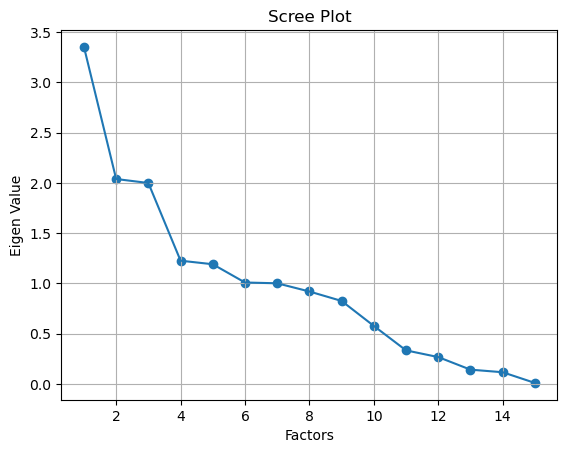

In [ ]:
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt

#Criteria 1
#Selecting the columns to include in the analysis of factors
columns_for_fa = ['Favourite Genre', 'Average Click Duration', 'Time of Day', 'Movie Preference', 'Average Time per Day', 'Frequent day', 'number_genres', 'Frequent month', 'Total films',
       'Weekday Click Frequency', 'Weekend Click Frequency', 'Year Duration Max', 'Days Since Last Click', 'Number of Films Before 2000', 'percentage']

#Creating a dataframe just with the selected columns
dataframe_for_fa = new_df[columns_for_fa]


#Copying the DataFrame
dataframe_for_fa_copy = dataframe_for_fa.copy()

#Substituting the infinites with NaN values
dataframe_for_fa_copy.replace([np.inf, -np.inf], np.nan, inplace=True)

#Last checking of NaNs
dataframe_for_fa = dataframe_for_fa_copy.dropna()

#Inizialising the object FactorAnalyzer
fa = FactorAnalyzer(rotation=None, impute="drop")

#Fit of the analysis of the factors
fa.fit(dataframe_for_fa)

#Obtaining the eigenvalues
ev, _ = fa.get_eigenvalues()

#Visualising the Scree Plot
plt.scatter(range(1, len(ev) + 1), ev)
plt.plot(range(1, len(ev) + 1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigen Value')
plt.grid()
plt.show()

From the graph we can see that the factors with eigenvalues greather than 1 are 6 or 7. Then to be sure about the number of factors, we see the precise values of the eigenvalues.

In [ ]:
#Values of the eigenvalues
print(ev)

[3.35338261 2.03856855 1.99889538 1.22558189 1.19022686 1.00845195
 1.00064298 0.91892207 0.82484091 0.57635718 0.33278009 0.26615328
 0.14098258 0.11532129 0.00889238]


As it is possible to see, the factors that have eigenvalues greather than 1 are 7. Then it is confirmed the result of the plot.
Now we use the second criteria and then we compare them.

In [ ]:
#Criteria 2
#Calculating the cumulative explained variance
cumulative_variance = np.cumsum(ev/15)
print(cumulative_variance)

[0.22355884 0.35946341 0.4927231  0.57442856 0.65377702 0.72100715
 0.78771668 0.84897815 0.90396755 0.94239136 0.9645767  0.98232025
 0.99171909 0.99940717 1.        ]


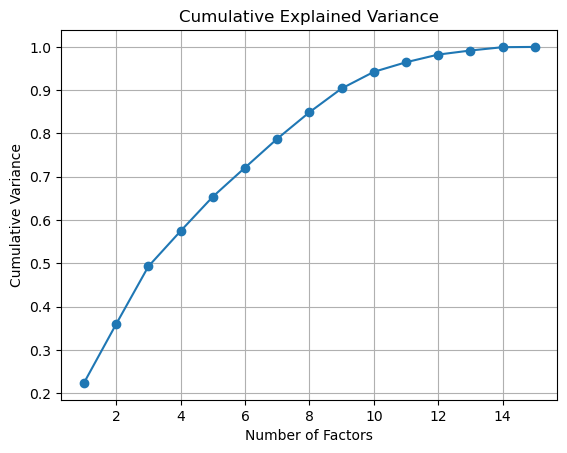

In [ ]:
#Visualising the cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Factors')
plt.ylabel('Cumulative Variance')
plt.grid()
plt.show()


From the second criteria we can see that 6 factors explain 72.1% of the variance, 7 factors 78.8% and 8 factors 84.9%. The optimal value is usually around 80%, but since the first criteria gave a result of 7 factors and the cumulative explained variance is 78.8%, we confirm 7 factors. Then we can find the final dataset with the 7 new features:

In [ ]:
#Factor Analysis with 7 factors
fa = FactorAnalyzer(n_factors=7, rotation=None, impute="drop")
fa.fit(dataframe_for_fa)

#Obtaining the transformed data based on 7 factors
factors_data = fa.transform(dataframe_for_fa)

#Creating a new dataset with the 7 factors
columns_factors = [f'Factor_{i+1}' for i in range(7)]
df_factors = pd.DataFrame(data=factors_data, columns=columns_factors)

# Riporta l'indice originale a new_df_factors
df_factors.reset_index(drop=True, inplace=True)

#Adding the column 'user_id' to the new DataFrame with the factors
df_factors['user_id'] = new_df['user_id']

#Final dataset
df_factors

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7,user_id
0,-0.600070,1.210697,-0.475207,-0.277602,1.268460,-1.267407,-0.491317,00004e2862
1,2.855532,1.048304,-0.120712,0.379591,0.529992,1.452220,-2.235053,000052a0a0
2,-0.553744,-0.155750,-0.276227,1.021043,-0.088991,0.556325,-0.065693,000090e7c8
3,-0.181568,-0.139962,-0.197543,-1.671997,0.406522,-2.056509,0.326917,000296842d
4,-0.065840,1.182586,-0.234082,-0.123853,-1.254068,-0.027865,0.517632,0002aab109
...,...,...,...,...,...,...,...,...
155843,-0.615313,1.159698,-0.397501,1.884660,0.974989,-0.386806,-0.125612,fffd9bf758
155844,-0.436502,1.166685,-0.383608,-0.915305,-0.371387,0.629544,0.336062,fffe7b777b
155845,1.141876,1.051822,-0.141074,1.626609,1.736041,-0.968510,0.472964,fffeac83be
155846,-0.396334,1.141319,-0.430913,1.390772,1.600539,0.912029,-0.714806,ffff2c5f9e


##### Interpretation of the Factors
For the interpretation of the Factors, first we see their weights respect to the original variables.

In [ ]:
#Fctors' Weights
factor_weights = fa.loadings_.T


#Selecting the weights of the Factor 1
weights_factor_1 = factor_weights[0]
#Obtaining the original variables with the highest weghts for Factor 1
top_variables_factor_1 = dataframe_for_fa.columns[np.abs(weights_factor_1).argsort()[-3:][::-1]]
#Printing the variables influenced by Factor 1
print(f"Variables influenced by Factor 1: {top_variables_factor_1}")

#Selecting the weights of the Factor 2
weights_factor_2 = factor_weights[1]
#Obtaining the original variables with the highest weghts for Factor 2
top_variables_factor_2 = dataframe_for_fa.columns[np.abs(weights_factor_2).argsort()[-3:][::-1]]
#Printing the variables influenced by Factor 2
print(f"Variables influenced by Factor 2: {top_variables_factor_2}")

#Selecting the weights of the Factor 3
weights_factor_3 = factor_weights[2]
#Obtaining the original variables with the highest weghts for Factor 3
top_variables_factor_3 = dataframe_for_fa.columns[np.abs(weights_factor_3).argsort()[-3:][::-1]]
#Printing the variables influenced by Factor 3
print(f"Variables influenced by Factor 3: {top_variables_factor_3}")

#Selecting the weights of the Factor 4
weights_factor_4 = factor_weights[3]
#Obtaining the original variables with the highest weghts for Factor 4
top_variables_factor_4 = dataframe_for_fa.columns[np.abs(weights_factor_4).argsort()[-3:][::-1]]
#Printing the variables influenced by Factor 4
print(f"Variables influenced by Factor 4: {top_variables_factor_4}")

#Selecting the weights of the Factor 5
weights_factor_5 = factor_weights[4]
#Obtaining the original variables with the highest weghts for Factor 5
top_variables_factor_5 = dataframe_for_fa.columns[np.abs(weights_factor_5).argsort()[-3:][::-1]]
#Printing the variables influenced by Factor 5
print(f"Variables influenced by Factor 5: {top_variables_factor_5}")

#Selecting the weights of the Factor 6
weights_factor_6 = factor_weights[5]
#Obtaining the original variables with the highest weghts for Factor 6
top_variables_factor_6 = dataframe_for_fa.columns[np.abs(weights_factor_6).argsort()[-3:][::-1]]
#Printing the variables influenced by Factor 6
print(f"Variables influenced by Factor 6: {top_variables_factor_6}")

#Selecting the weights of the Factor 7
weights_factor_7 = factor_weights[6]
#Obtaining the original variables with the highest weghts for Factor 7
top_variables_factor_7 = dataframe_for_fa.columns[np.abs(weights_factor_7).argsort()[-3:][::-1]]
#Printing the variables influenced by Factor 7
print(f"Variables influenced by Factor 7: {top_variables_factor_7}")


Variables influenced by Factor 1: Index(['Total films', 'Weekday Click Frequency', 'Weekend Click Frequency'], dtype='object')
Variables influenced by Factor 2: Index(['Year Duration Max', 'Days Since Last Click', 'Frequent month'], dtype='object')
Variables influenced by Factor 3: Index(['Average Click Duration', 'Average Time per Day', 'percentage'], dtype='object')
Variables influenced by Factor 4: Index(['Favourite Genre', 'Frequent month', 'Days Since Last Click'], dtype='object')
Variables influenced by Factor 5: Index(['Frequent month', 'Favourite Genre', 'Days Since Last Click'], dtype='object')
Variables influenced by Factor 6: Index(['Frequent day', 'Weekday Click Frequency', 'Weekend Click Frequency'], dtype='object')
Variables influenced by Factor 7: Index(['Number of Films Before 2000', 'Movie Preference', 'Favourite Genre'], dtype='object')


We can visualize the correlations between the Factors and the features of new_df.

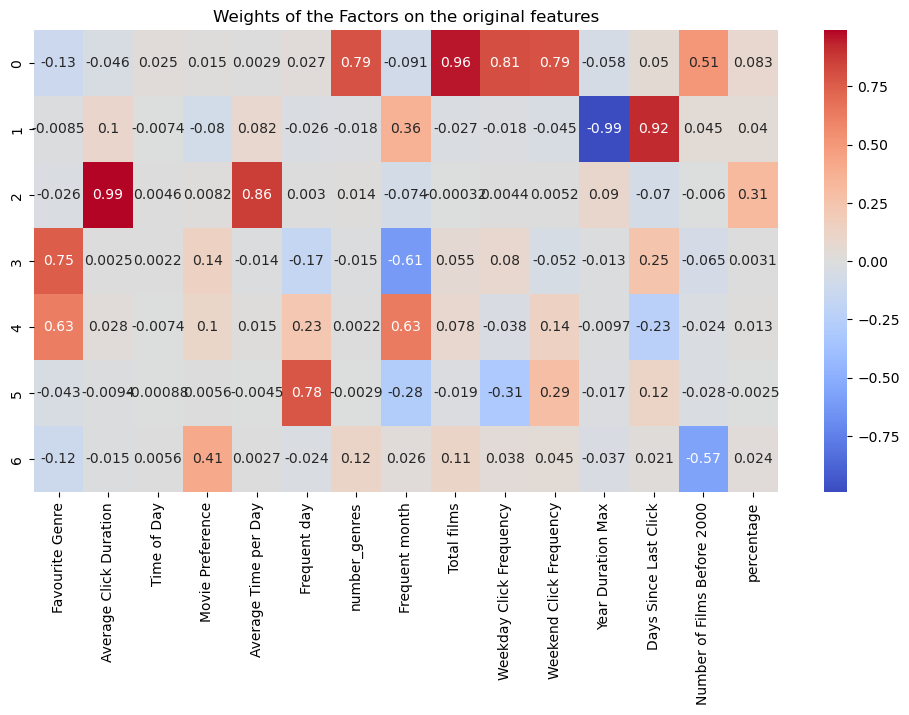

In [ ]:
import seaborn as sns
#Heatmap: correlations between factors and the original features
plt.figure(figsize=(12, 6))
sns.heatmap(factor_weights, annot=True, xticklabels=dataframe_for_fa.columns, cmap='coolwarm')
plt.title('Weights of the Factors on the original features')
plt.show()

Note: in the Heatmap thue Factors go from 0 to 6, but we define them from 1 to 7.

From the Heatmap we can say that:
- Factor 1 is positive influenced by 'Total Films', 'Weekday Click Frequency', 'Weekend Click Frequency' and 'number_genres', so to the increase of of the number of films, corresponds an increase of the other variables;
- Factor 2 is negative correlated with 'Year Duration Max' and positive correlated to 'Days since last click', then the more is the number of days since last click, the less is the year with the maximum average duration ('Year Duration Max' is a dummy that represent the years 2017, 2018, 2019);
- Factor 3 shows a positive correlation with 'Average Click Duration' and 'Average Time per Day', then to the average duration of a click corresponds an average daily time;
- Factor 4 is positve correlated to 'Favourite Genre' and negative correlated to 'Frequent month';
- Factor 5 has the same positive correlation with 'Favourite Genre' and 'Frequent month';
- Factor 6 has a positive correlation with 'Frequent day'. For this factor it is interesting to notice that this factor has a low negative correlation with 'Weekday Click Frequency' and a low positive correlation with 'Weekend Click Frequency', then to the increase of this factor for a certain user corresponds a higher frequency of the clicks during the weekend;
- Factor 7 is low positive correlated to 'Movie Preference' and negative correlated to 'Number of Films Before 2000', since the variable about preference of the movies has the modalities 1 for "Old movie lover" (before 2010) and 2 for "Recent movie lover". Then, the bigger is the number of films realized before 2000 seen by a certain user, the lower is the preference.

### 2.3 Clustering!

### 2.3.1: Implement the K-means clustering algorithm (not ++: random initialization) using MapReduce
Constructing the algorithm is a lot easier with an input(our data set we received after the dimensionality reductionp), this is why 2.3.1 and 2.3.3 are solved in one step. The algorithm will be called again later on with the optimal cluster size.
First we have to import the necessary libraries.

In [ ]:
#Libraries for the visulaization of our clusters
from sklearn.decomposition import PCA
from IPython.display import clear_output

#Library for scaling the dataframe
from sklearn.preprocessing import StandardScaler

In [ ]:
data = df_factors.drop('user_id', axis=1)
data

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7
0,-0.600070,1.210697,-0.475207,-0.277602,1.268460,-1.267407,-0.491317
1,2.855532,1.048304,-0.120712,0.379591,0.529992,1.452220,-2.235053
2,-0.553744,-0.155750,-0.276227,1.021043,-0.088991,0.556325,-0.065693
3,-0.181568,-0.139962,-0.197543,-1.671997,0.406522,-2.056509,0.326917
4,-0.065840,1.182586,-0.234082,-0.123853,-1.254068,-0.027865,0.517632
...,...,...,...,...,...,...,...
155843,-0.615313,1.159698,-0.397501,1.884660,0.974989,-0.386806,-0.125612
155844,-0.436502,1.166685,-0.383608,-0.915305,-0.371387,0.629544,0.336062
155845,1.141876,1.051822,-0.141074,1.626609,1.736041,-0.968510,0.472964
155846,-0.396334,1.141319,-0.430913,1.390772,1.600539,0.912029,-0.714806


As we will be dealing with distances, we have to scale our data, in order to avoid, that some features have a bigger influence than others. It standardizes the features indepently by removing the mean and scaling to unit variance.

In [ ]:
scaler = StandardScaler()
scaler.fit(data)
scaled = scaler.transform(data)
data = pd.DataFrame(scaled, columns=data.columns)

We write a function that selects our first centroids randomly. This is done by just picking some datapoints. This function will return a dataframe. We want the centroids to be columns, so we transpose the dataframe before returning it.

In [ ]:
# Randomly select centroids from the dataset
def random_centroids(data, k):
    centroids=data.sample(k)
    return centroids.T

We write our map function. This function will return the index of the closest centroid for each datapoint as a pandas series

In [ ]:
#Map function
def mapping(data, centroids):
    #Calculates the squared distance of every centroid with every datapoint
    distances = centroids.apply(lambda x: (((data-x)**2)).sum(axis=1))
    #returns the index of the closest cluster for every datapoint
    return distances.idxmin(axis=1)

Now we write our reduce function. It reallocates the centroids to the positon, that minimizes the distances of the datapoints that were assigned to the respective centroid.This function returns a dataframe, that is again transpozed as we want the centroids to be columns.

In [ ]:
#Reduce Function
def reduce(data, clusters, k):
    #groups the data by the clusters from the map function and calculates the arithmetic mean for each of these groups
    return data.groupby(clusters).apply(lambda x: x.mean()).T

The next step is not a an actual part of an algorithm, but as we want to visualize our results, in order to see if they are reasonable, we write another function to plot our clusters. We do this by making our data two dimensional.
The title of our plot is the current iteration, as we write the function in a way that it displays our clusters for each iteration, in order to see if the development makes sense.

In [ ]:
#Visualizing plots
def plot_clusters(data, clusters, centroids, iteration):
    #Initializing our PCA with 2 columns
    pca= PCA(n_components= 2)
    #Fit and transform our data to two dimensions
    data_2d= pca.fit_transform(data)
    #Fit and transform our centroids to two dimensions, we have to transform the dataframe, because the PCA expects the cnetroids to be rows
    centroids_2d= pca.transform(centroids.T)
    #Output is cleared after every iteration, so new output can be shown
    clear_output(wait= True)
    #Set title
    plt.title(f' Iteration {iteration}')
    #Plot each datapoint to our graph and colour it according to clusters
    plt.scatter(x=data_2d[:,0], y= data_2d[:,1], c=clusters)
    #Plot the centroids to our graph
    plt.scatter(x=centroids_2d[:,0], y= centroids_2d[:,1], c='red')
    #Show the plot
    plt.show()
    

Now we have all the functions we need to pull our algorithm together. The first centroids are chosen randomly(random_centroids function). Afterwards each datapoint is assgined to a cluster(mapping function) and the new centroids of that clusters are getting computed(reduce function). This process is being repeated until the the centroids don't change anymore or the max_iterations criteria is met to avoid an infinte loop.The result of every iteration is always getting visualized(plot_clusters function) The number of the max_iterations is chosen arbitrarily, as well as the number of k(number of clusters). We just want to check if our algorithm is working.

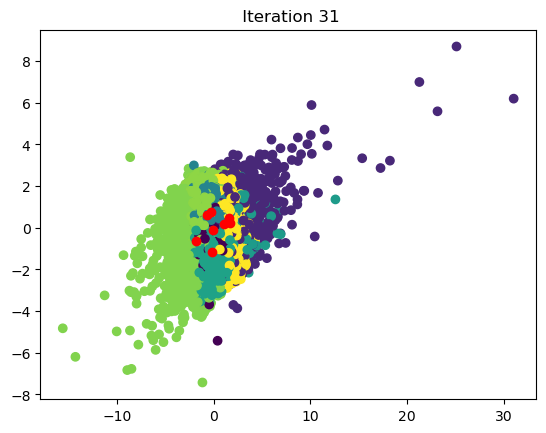

In [ ]:
#criteria to break the loop
max_iterations= 100
#number of clusters
k=8
#We ranndomly choose our first centroids
centroids= random_centroids(data, k)
#Initialization of an empty dataframe to store the previous centroids
old_centroids= pd.DataFrame()
#Initialization of iteration count
iteration=1

#loop
while iteration < max_iterations and not centroids.equals(old_centroids):
    #old centroids are getting assigned
    old_centroids= centroids.copy()
    #Map
    clusters= mapping(data, centroids)
    #Reduce
    centroids= reduce(data, clusters, k)
    #Visualization
    plot_clusters(data, clusters, centroids, iteration)
    #Adjusting counter
    iteration+=1

#### 2.3.2: Find an optimal number of clusters
For this part we decided to use two methods: Elbow method and silhouette method.

##### Elbow method
The elbow method works a follows: We first define a possible range for the possible number of clusters(in our case 1 to 15). For each number of clusters the initial centroids are chosen randomly and the SSE is being computed by applying the Kmeans algorithm from the sklearn library. This will be repeated for a predefined amount of times (in our case 10) and only the smallest SSE value for the specific number of clusters is returned. Afterwards we have a list of SSE's for the different numbers of clusters and plot the against each other. Then we have to visually evaluate which is the perfect cluster size. The optimal cluster size is the one, where a bend in the slope(elbow) can be seen. As the evaluation is visual, it only works well for data that is well clustered and the bend can be easily identified.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans_paras = {
  "init": "random", #The initial centroids are chosen randomly
  "n_init": 15, #K-means algorithm is run 10 times with different centroids, the centroids with the smallest number of SSE are returned
  "random_state": 1, #Ensures the reproducibility of results
}

In [ ]:
#Initialize a list of SSE's
sse = []
#Loop over different amounts of clusters. In this example: 1 to 15
for k in range(1, 16): 
    #Create a k-means object
    kmeans = KMeans(n_clusters=k, **kmeans_paras)
    #Fit the k-means object to the data
    kmeans.fit(data)
    #Appends the SSE to the list
    sse.append(kmeans.inertia_)

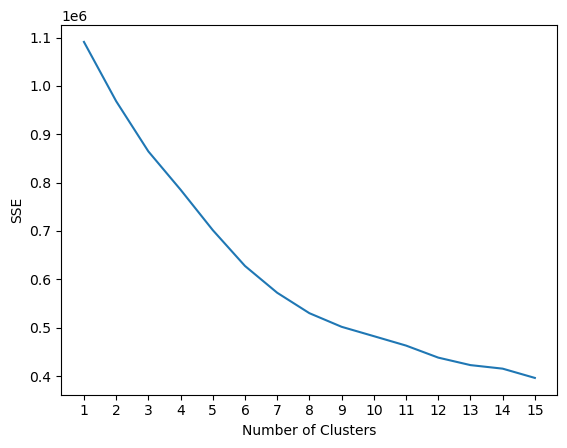

In [ ]:
#Visualising
#Plot the SSE values against the number of clusters
plt.plot(range(1, 16), sse)
plt.xticks(range(1, 16))
#Name the x-/ and y-achsis
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
#Show the plot
plt.show()

We really have problems identifying the 'elbow'. It could be at 7,8 or 9. Next we we will try the silhouette method and see, which results it gives us.

##### Silhouette method
Now we are going to use the Silhouette method. It works as follows: We first define a possible range for the possible number of clusters(in our case 1 to 15). For each number of clusters the initial centroids are chosen randomly and the SSE is being computed by applying the Kmeans algorithm from the sklearn library.This will be repeated for a predefined amount of times (in our case 10) and for the smallest SSE value for the specific number of clusters the Sihlouette score gets computed.The Silhouette score is a ratio of how similar a sample is to its own cluster compared to other clusters. It ranges from -1 to 1 and indicates how well clustered the data is. The sihlouette scores are stored in a dictionnary as values with the corresponding  number of clusters as key. To find the optimal number of clusters we have to extract the key of the highest score from the dictionnary.

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
kmeans_paras = {
 "init": "random", #The initial centroids are chosen randomly
 "n_init": 15, #K-means algorithm is run 10 times with different centroids, the centroids with the smallest number of SSE are returned
 "random_state": 1, #Ensures the reproducibility of results
}

In [ ]:
#Initialize the dictionnary
silhouette_scores = {}
#Loop over different amounts of clusters. In this example: 1 to 15
for k in range(2, 16):
    #Create a k-means object
    kmeans = KMeans(n_clusters=k, **kmeans_paras)
    #Fit the k-means object to the data
    kmeans.fit(data)
    #Calculates the Silhouette score
    score = silhouette_score(data, kmeans.labels_)
    # Stores the sihlouette score with the number of clusters as key in a dictionnary
    silhouette_scores[k] = score
    print(score)

0.15076100742485088
0.17782759701918627
0.18717153456651472
0.18665545149787546
0.19899175425793034
0.2066368126310924
0.20616166148843248
0.19969124563932397
0.20099898895205873
0.19759238690829953
0.19855801104562612
0.20302767168674213
0.19980607774281864
0.20232687208156966


In [ ]:
#Extract the number of clusters with the highest score
optimal_k = max(silhouette_scores, key=silhouette_scores.get)

#Final results
optimal_k

7

According to the Silhouette score our optimal cluster size is 7.

The evaluate the optimal amount of clusters we decide to go with the Sihlouette method. We do this mainly for the reason, that we can can perfectly see the weakness of the elbow method in our case. Our clusters are quite weak, which is also displayed by the low sihlouette scores we get. This means that it is really hard to visually find the
'elbow' in our plot. It could be argued, that it is also at a cluster size of seven, but can't be clearly evaluated. The disadvantage of the Silhouette score is, that it has a way longer running time than the elbow method.

Now we run our k-means algorithm as well with the optimal cluster size of 7.

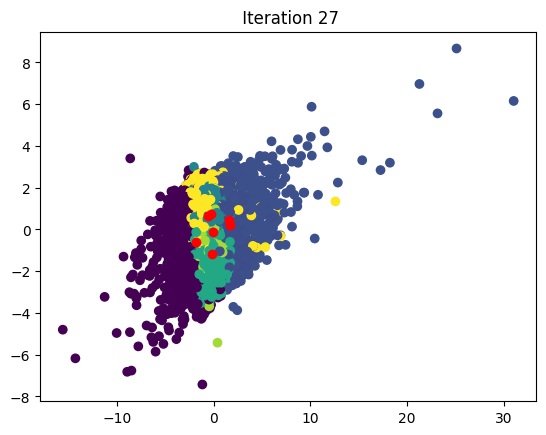

In [ ]:
#criteria to break the loop
max_iterations= 100
#number of clusters
k=7
#We ranndomly choose our first centroids
centroids= random_centroids(data, k)
#Initialization of an empty dataframe to store the previous centroids
old_centroids= pd.DataFrame()
#Initialization of iteration count
iteration=1

#loop
while iteration < max_iterations and not centroids.equals(old_centroids):
    #old centroids are getting assigned
    old_centroids= centroids.copy()
    #Map
    clusters= mapping(data, centroids)
    #Reduce
    centroids= reduce(data, clusters, k)
    #Visualization
    plot_clusters(data, clusters, centroids, iteration)
    #Adjusting counter
    iteration+=1

Our clusters don't seem proper. Now we will try to implement the K-means++ and see if it gives us different results.

#### 2.3.4:Implement K-means++ from scratch and explain the differences with the results you got earlier.

The K-means++ algorithm differs from the k-means algorithm in the way the initial centroids are chosen. Instead of choosing all the initial centroids randomly, this is only done for the first one. Afterwards the datapoints get weights that are proportional to the distance to the nearest centroid. The next centroid is then chosen (randomly) with respect to the probabilities. This makes the algorithm way more efficient.

In order to write the new random_centroids function, which creates the initial centroids, we have to first write two helping functions

The first helping function calculates the squared distance between a centroid and each datapoint. It returns a pandas series.

In [ ]:
def calco_distances(centroid, data):
    distances = data.apply( lambda row : ((centroid-row)**2).sum(axis=1), axis=1)
    #distances = data.apply(lambda row: np.sum((centroid - row)**2), axis=1)
    return distances

The next helping function chooses the next centroid by choosing random with respect to the probabilities that are proprotional to the distance to the nearest centroid.

In [ ]:
def get_centroid(distances):
    #Assigning the weights for the probabilities: They get assigned the distance. The reshape is necessary as they were a list of lists before which was not compatible with the random choice function
    weights = distances.to_numpy().reshape(-1)
    #Get new centroid with respect to probabilities. probabilitiy= distance/ sum of all distances
    centroid = np.random.choice( np.arange(0,len(data)), p=weights/sum(weights))
    #We return centroid as a dataframe and transpose it 
    return pd.DataFrame(data.iloc[centroid,]).T

Now we have our helping functions and we can pull the new random_centroid function together.

In [ ]:
def random_centroids(data, k):
    #We initialize dataframes to store our centroids and distances
    centroids= pd.DataFrame()
    df_distances = pd.DataFrame()
    #We loop over the number of needed centroids
    for i in range(k):
        # if condition for creation of first centroid
        if len(centroids) == 0:
            #randomly choose a datapoint as first centroid
            centroid = data.sample(n=1).copy()
        #else condition, that always gets entered after the first centroid was created
        else:
            distances = df_distances.min(axis=1)
            centroid = get_centroid(distances)
        centroids = pd.concat([centroids, centroid])
        # creating a column in our df_distances dataframe that stores the distances of each datapoint to the respective centroid
        df_distances[str(i)] = calco_distances(centroid, data)
    return centroids.T

Besides the new function to create the initial centroids, the other functions remain the same as for the k-means algorithms. Therefor there won't be any further comments on them.

In [ ]:
#Map function
def mapping(data, centroids):
    #Calculates the squared distance of every row with every datapoint
    distances = centroids.apply(lambda x: (((data-x)**2)).sum(axis=1))
    #returns the index of the closest cluster for every datapoint
    return distances.idxmin(axis=1)

In [ ]:
#Reduce Function
def reduce(data, clusters, k):
    #groups the data by the clusters from the map function and calculates the arithmetic mean for each of these groups
    return data.groupby(clusters).apply(lambda x: x.mean()).T

In [ ]:
#Visualize plots
def plot_clusters(data, clusters, centroids, iteration):
    #Initializing our PCA with 2 columns
    pca= PCA(n_components= 2)
    #Fit and transform our data to two dimensions
    data_2d= pca.fit_transform(data)
    #Fit and transform our centroids to two dimensions, we have to transform the dataframe, because the PCA expects the cnetroids to be rows
    centroids_2d= pca.transform(centroids.T)
    #Output is cleared after every iteration, so new output can be shown
    clear_output(wait= True)
    #Set title
    plt.title(f' Iteration {iteration}')
    #Plot each datapoint to our graph and colour it according to clusters
    plt.scatter(x=data_2d[:,0], y= data_2d[:,1], c=clusters)
    #Plot the centroids to our graph
    plt.scatter(x=centroids_2d[:,0], y= centroids_2d[:,1], c='red')
    #Show the plot
    plt.show()

Now we run our K++ means algorithm.

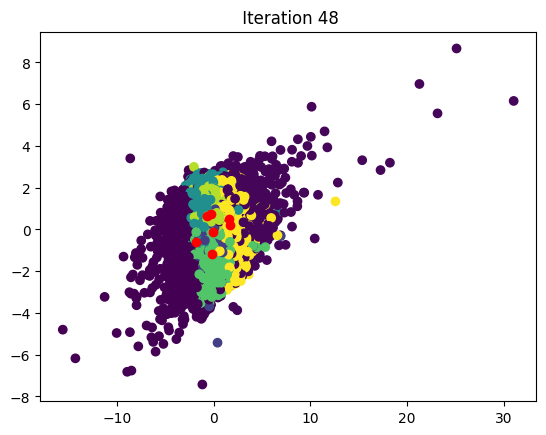

In [ ]:
max_iterations= 100
k=7
centroids= random_centroids(data, k)
old_centroids= pd.DataFrame()
iteration=1
while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids= centroids
    
    clusters= mapping(data, centroids)
    centroids= reduce(data, clusters, k)
    plot_clusters(data, clusters, centroids, iteration)
    iteration+=1

We can't see a significant difference in the clustering compared to the K-means algorithm, which is very likely due to the fact that our data is not suitable for partitional clustering.

#### 2.3.5: Other clustering from ChatGPT
Here is the implemantation of Chat GPT, adjusted to our data:

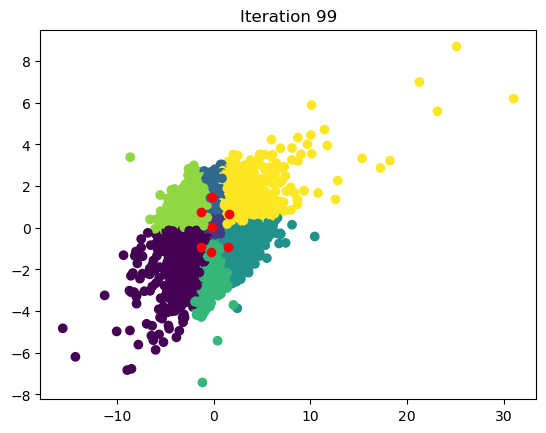

In [ ]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Fit PCA on the original data
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)

kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(data_2d)

# Fit PCA on the cluster centers
pca_centroids = PCA(n_components=2)
centroids_2d = pca_centroids.fit_transform(kmeans.cluster_centers_)

for iteration in range(100):
   clear_output(wait=True)
   plt.title(f'Iteration {iteration}')
   plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=kmeans.labels_)
   plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1], c='red')
   plt.show()

The results we get from the implementation with ChatGPT seem way better, than the ones we get from our own implementation form scratch. This is probably due to some error in our code or our visualization, which we are not able to find.

#### 2.4: Analysing your results!

#### Select 2-3 variables you think are relevant to identify the cluster of the customer. For example, Time_Day, Average Click Duration, etc.

We choose the variables 'Average Time per Day' and 'Time of Day'. First we have to do a new clustering, as we can't get the individual features anymore after the dimensionality reduction. We take the dataset we created before the dimensionality reduction and drop the column 'user_id'. As we have numerical and categorical data we apply a mixture of the gower distance and the kmodes algorithm. As this is very memory-expensive we only work on a subset of the data, which we create in a first step. 

In [ ]:
#Drop column 'user_id'
data_2_4 = data_2_4.drop('user_id', axis=1)
# Create a subset of your data
data_subset = data_2_4.sample(n=10000, random_state=1)

In [ ]:
data_subset

,Favourite Genre,Average Click Duration,Time of Day,Movie Preference,Average Time per Day,Frequent day,number_genres,Frequent month,Total films,Weekday Click Frequency,Weekend Click Frequency,Year Duration Max,Days Since Last Click,Number of Films Before 2000,percentage
96854,8,21.90,2,2,21.90,7,1,6,1,0,1,3,6,0,0.00
99515,1,0.00,2,2,0.00,5,6,3,1,0,6,3,99,0,0.00
24868,3,247.09,3,2,823.64,3,15,1,6,8,12,2,490,1,45.00
32967,3,351.55,3,2,1406.20,1,14,4,12,25,11,1,797,0,52.78
3488,2,12.22,3,2,61.08,6,5,11,1,0,5,1,588,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115566,4,2.44,3,1,51.18,3,10,4,4,21,0,2,451,4,0.00
115112,3,0.00,2,1,0.00,4,2,9,1,2,0,2,275,0,0.00
67684,2,28.04,2,2,56.08,2,4,4,3,5,1,3,32,0,16.67
159398,3,1.25,2,1,2.50,2,2,12,1,2,0,2,200,0,0.00


In the next step we install the necessary packages and import the libraries

In [ ]:
!pip install gower

In [ ]:
!pip install scikit-learn-extra

In [ ]:
import gower
from sklearn_extra.cluster import KMedoids
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler

Before we can get our clusters, we first have to know the optimal cluster size. Therefor we normalize our numercial data using the MinMaxScaler. Our categorical data is already encoded.

In [ ]:
#Create a new dataframe with the numerical columns
numerical_columns = ['Average Click Duration', 'Average Time per Day', 'number_genres', 'Total films', 'Weekday Click Frequency', 'Weekend Click Frequency', 'Days Since Last Click', 'Number of Films Before 2000', 'percentage']
df_numerical = data_subset[numerical_columns]

#Scale the numerical columns
scaler = MinMaxScaler()
scaled_numerical = scaler.fit_transform(df_numerical)
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_columns)
scaled_numerical_df.reset_index(drop=True, inplace=True)

# Create a new dataframe for the categorical columns
categorical_columns = ['Favourite Genre', 'Time of Day', 'Movie Preference', 'Frequent day','Frequent month', 'Year Duration Max']
df_categorical = data_subset[categorical_columns]
df_categorical.reset_index(drop=True, inplace=True)

# Concatenate the scaled numerical dataframe and the categorical dataframe
df_scaled = pd.concat([scaled_numerical_df, df_categorical], axis=1)

Now we apply the elbow method on this dataset

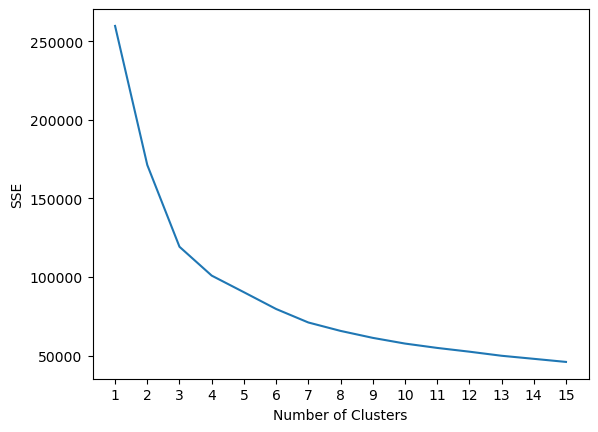

In [ ]:
kmeans_paras = {
  "init": "random", #The initial centroids are chosen randomly
  "n_init": 15, #K-means algorithm is run 10 times with different centroids, the centroids with the smallest number of SSE are returned
  "random_state": 1, #Ensures the reproducibility of results
}

#Initialize a list of SSE's
sse = []
#Loop over different amounts of clusters. In this example: 1 to 15
for k in range(1, 16): 
    #Create a k-means object
    kmeans = KMeans(n_clusters=k, **kmeans_paras)
    #Fit the k-means object to the data
    kmeans.fit(df_scaled)
    #Appends the SSE to the list
    sse.append(kmeans.inertia_)
    
#Visualising
#Plot the SSE values against the number of clusters
plt.plot(range(1, 16), sse)
plt.xticks(range(1, 16))
#Name the x-/ and y-achsis
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
#Show the plot
plt.show()

As we can see the optimal cluster size is 4. Now we can apply our clusetering. As the kmodes and the gower matrix are both not distance metrics, we don't need to scale our data 

In [ ]:
# Creating a Gower matrix 
gower_mat = gower.gower_matrix(data_subset, cat_features = [True, False, True, True, False, True, False, True, False, False, False, True, False, False, False])

# Fitting the K-Medoids model
km_model = KMedoids(n_clusters = 4, random_state = 0, metric = 'precomputed', method = 'pam', init = 'k-medoids++').fit(gower_mat) 

# Get the clusters
clusters = km_model.labels_ 

We store the cluster assignents as a new column in our dataframe

In [ ]:
data_subset['cluster'] = clusters

#### Most of your selected variables will be numerical (continuous or discrete), then categorize them into four categories.

The variable 'Time of Day' is categorical and therefor doesn't need to be grouped. For the variable 'Average Time per Day' the 4 categories are needed. To do the assignment properly, we first assess the distribution of the values in that column.

In [ ]:
data_subset['Average Time per Day'].quantile([0.25, 0.5, 0.75])

0.25       0.0000
0.50     206.4750
0.75    1807.3175
Name: Average Time per Day, dtype: float64

Now we create the categories based on the distribution of our data and store it in a new column 'Average Time per Day_category'

In [ ]:
# Defining the boundaries
bins = [-0.001,0.0100, 206.4750, 1807.3175, np.inf] 

# Defining the categories
names = ['0', '0-206.4750', '206.4750-1807.3175', '>1758.1875']

data_subset.loc[:, 'Average Time per Day_category'] = pd.cut(data_subset['Average Time per Day'], bins, labels=names)

#### With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.

Our first pivot table is for the 'Time of Day' feature. As the categories are still encoded, we rename them after creating the table. 

In [ ]:
#Creating the pivot table
pivot_table = data_subset.pivot_table(index='cluster', columns='Time of Day', aggfunc='size', fill_value=0)
#Renaming the columns
pivot_table = pivot_table.rename(columns={'1': 'Morning', '2': 'Afternoon', '3': 'Night'})
pivot_table

Time of Day,Morning,Afternoon,Night
cluster,,,
0,411,351,1410
1,393,1264,389
2,593,581,1769
3,497,365,1977


Our second pivot table is for the 'Average Time per Day' feature. 

In [ ]:
#Creating the pivot table
pivot_table2 = data_subset.pivot_table(index='cluster', columns='Average Time per Day_category', aggfunc='size', fill_value=0)
pivot_table2

Average Time per Day_category,0,0-206.4750,206.4750-1807.3175,>1758.1875
cluster,,,,
0,465,479,603,625
1,349,470,652,575
2,693,707,766,777
3,1038,799,479,523


#### Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100.

In [ ]:
pivot_table_perc1 = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100
pivot_table_perc1

Time of Day,Morning,Afternoon,Night
cluster,,,
0,18.922652,16.160221,64.917127
1,19.208211,61.779081,19.012708
2,20.149507,19.741760,60.108733
3,17.506164,12.856640,69.637196


In [ ]:
pivot_table_perc2 = pivot_table2.div(pivot_table.sum(axis=1), axis=0) * 100
pivot_table_perc2

Average Time per Day_category,0,0-206.4750,206.4750-1807.3175,>1758.1875
cluster,,,,
0,21.408840,22.053407,27.762431,28.775322
1,17.057674,22.971652,31.867058,28.103617
2,23.547401,24.023106,26.027863,26.401631
3,36.562170,28.143713,16.872138,18.421980


#### Interpret the results for each pivot table.

When looking at the Pivot table for the 'Time of Day' feature it comes to eye, that in all clusters, except cluster 1, users that consume during the night are dominant. This comes as no suprise, as it is the biggest group, which can be also derived from the pivot table with absolute numbers.
Nevertheless there is an indicator, that the 'Time of Day' feature is relevant to identify the cluster of the user. Cluster 1 predominantly contains users that consume in the afternoon and therfor it is likely,  that the 'Time of Day' feature is responsible that these users got assigned to that cluster. Clusters 0, 2 and 3 consist of around two thirds of users who consume during the night. There is only a small difference between the distribution of the last third between Morning and Afternoon. Therefore, the allocation to these clusters is probably due to other features.


On the first glance the feature how much the users consumed doesn't seem to play a big role in the cluster assignment. The beaviour of the users (captured by iur other features) who consume a lot on average, might not largely differ from the behvaviour of the users that hardly consume anything at all. If we take a closer look we can see some differences: Cluster 0 and 2 seem to capture users that spend different averages of time on netflix to the same percentages. Cluster 3 seems to capture more of the users that don't spend a lot of time on the platform, while the opposite is true for cluster 1. We can conclude that the feature 'Average Time per Day' might give some hints to identify the cluster of a user, but with only this feature they can't be identified. 

#### Use any known metrics to estimate clustering algorithm performance (how good are the clusters you found?). Comment on the results obtained

In [ ]:
data_subset = data_subset.drop('Average Time per Day_category', axis=1)

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
sil_score = silhouette_score(data_subset, clusters)
print(f'Silhouette Score: {sil_score}')


Silhouette Score: -0.09028214905306818


In [ ]:
from sklearn.metrics import davies_bouldin_score

# Calculate Davies-Bouldin score
db_score = davies_bouldin_score(data_subset, clusters)
print(f'Davies-Bouldin Score: {db_score}')

Davies-Bouldin Score: 21.562142639646897


The clusters I have found are really bad. The sihlouette score is slightly negative, which means that the clusters can't be clearly distinguished from each other or are possibly even overlapping. To reassure ourselves, that the clusters we have found are really that bad, we also calculate the Davies-Bouldin score. With a score of more than 21 it reassures our suspicion, that our clusters can't be seperated clearly.The reason could be that our clustering algorithm doesn't work well, or our data is just not well seperable. These results also make sense when we look at the interpretation of our pivot tables. The features we thought of to be key to identify the cluster of a customer, didn't really do so.

--------------------

### 3: Bonus Question

The suggestions from CHATGPT are these three:
- DBSCAN (Density-Based Spatial Clustering of Applications with Noise): it identifies clusters with arbitrary shapes, detects clusters surrounded or overlapped by other clusters, makes sense of noise, it is good for anomaly detection (robust to outliers) and it doesn't require to specify the total number of clusters.
- OPTICS (Ordering Points to Identify Clustering Structure): it's about extracting the clustering structure of a dataset by identifying the density-connected points. It is connected to the concept of reachability distance, which measures the density at a particular point and its ability to reach other points.
- HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise): it has a hierarchical approach to clustering and it builds a cluster hierarchy.

We decided for the firt one, the DBSCAN, since it doesn't require to specify the number of clusters. We explored different combinations of DBSCAN parameters, specifically `epsilons2` (radius for neighborhood definition) and `min_samples2` (minimum number of samples in a neighborhood). More deeply, Epsilon is the maximum distance between two points to be considered neighbors, and the points that are within this distance are connected to form a cluster. It's the parameter that defines the "maximum distance" a point can be from its neighbors to be part of the same cluster. On the other hand, the minimum of samples is the minimum number of points that must be within a distance of epsilon to form a cluster. This parameter helps define the density required to form a cluster.

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

#Taking the columns of the factors (removing 'user_id')
mydata = df_factors.drop('user_id', axis=1).values
mydata.shape

#Defining the possible parameters for DBSCAN
epsilons2 = np.linspace(0.01, 1, num=10)
min_samples2 =np.arange(2, 40, step=3)

In [ ]:
import itertools

#Generating combinations of parameters
combinations2 = list(itertools.product(epsilons2, min_samples2))
combinations2

#Number of combinations
N2=len(combinations2)
N2

130

After finding the possible combinations, we fit a DBSCAN model and evaluate its performance using the silhouette score. The silhouette score measures how well-defined the clusters are in the data. We identified the combination of parameters that yields the highest silhouette score, indicating the most appropriate clustering.

In [ ]:
from sklearn.metrics import silhouette_score

def get_scores_and_labels(combinations, mydata):
    scores = []
    all_labels_list = []

    for i, (eps, num_samples) in enumerate(combinations):
        print(f"Trying combination: eps={eps}, min_samples={num_samples}")
        try:
            #Fit DBSCAN model
            dbscan_cluster_model = DBSCAN(eps=eps, min_samples=num_samples).fit(mydata)
            labels = dbscan_cluster_model.labels_
            labels_set = set(labels)
            num_clusters = len(labels_set)

            #Removing noise (-1) from cluster count
            if -1 in labels_set:
                num_clusters -= 1

            #Evaluating the combination using silhouette score
            if (num_clusters < 2) or (num_clusters > 50):
                scores.append(-10)
                all_labels_list.append('bad')
                print(f"Combination {i+1} of {len(combinations)} has {num_clusters} clusters. Skipping.")
                continue

            score = silhouette_score(mydata, labels)
            scores.append(score)
            all_labels_list.append(labels)
            print(f"Combination {i+1} of {len(combinations)} - Silhouette Score: {score}, NumClusters: {num_clusters}")

        except Exception as e:
            print(f"Error in combination {i+1} of {len(combinations)}: {str(e)}")
    
    #Finding the best combination based on the maximum silhouette score
    best_index = np.argmax(scores)
    best_parameters = combinations[best_index]
    best_labels = all_labels_list[best_index]
    best_score = scores[best_index]

    return {
        'best_epsilon': best_parameters[0],
        'best_min_samples': best_parameters[1],
        'best_labels': best_labels,
        'best_score': best_score
    }

#Getting the best parameters and labels
best_dict2 = get_scores_and_labels(combinations2, mydata)
print("Best Parameters:", best_dict2)


Trying combination: eps=0.01, min_samples=2
Combination 1 of 130 has 9308 clusters. Skipping.
Trying combination: eps=0.01, min_samples=5
Combination 2 of 130 has 1550 clusters. Skipping.
Trying combination: eps=0.01, min_samples=8
Combination 3 of 130 has 488 clusters. Skipping.
Trying combination: eps=0.01, min_samples=11
Combination 4 of 130 has 164 clusters. Skipping.
Trying combination: eps=0.01, min_samples=14
Combination 5 of 130 has 59 clusters. Skipping.
Trying combination: eps=0.01, min_samples=17
Combination 6 of 130 - Silhouette Score: -0.5138537376567608, NumClusters: 26
Trying combination: eps=0.01, min_samples=20
Combination 7 of 130 - Silhouette Score: -0.47776237042113734, NumClusters: 20
Trying combination: eps=0.01, min_samples=23
Combination 8 of 130 - Silhouette Score: -0.40561529604309804, NumClusters: 11
Trying combination: eps=0.01, min_samples=26
Combination 9 of 130 - Silhouette Score: -0.39542581176378044, NumClusters: 8
Trying combination: eps=0.01, min_samp

The resulting parameters and cluster labels are stored in `best_dict2`.

In [ ]:
best_dict2

{'best_epsilon': 1.0,
 'best_min_samples': 23,
 'best_labels': array([ 0, -1,  0, ...,  0,  0,  0], dtype=int64),
 'best_score': 0.5221149659307022}

We created a pandas DataFrame with cluster labels and merge it with the original dataset. The count of occurrences for each cluster is displayed to assess the distribution.

In [ ]:
import pandas as pd

#Converting the array of labels into a pandas Series
cluster_series2 = pd.Series(best_dict2['best_labels'], name='cluster')

#Creating a DataFrame with the Series of labels
cluster_df2 = pd.DataFrame(cluster_series2)

#Merging the cluster DataFrame with the original DataFrame
mydata_with_clusters2 = pd.concat([pd.DataFrame(mydata), cluster_df2], axis=1)

#Counting the occurrences of each cluster
cluster_counts2 = mydata_with_clusters2['cluster'].value_counts()
print(cluster_counts2)

cluster
 0    151769
-1      4056
 1        23
Name: count, dtype: int64


Finally, we used seaborn to visualize the clusters in a scatter plot.

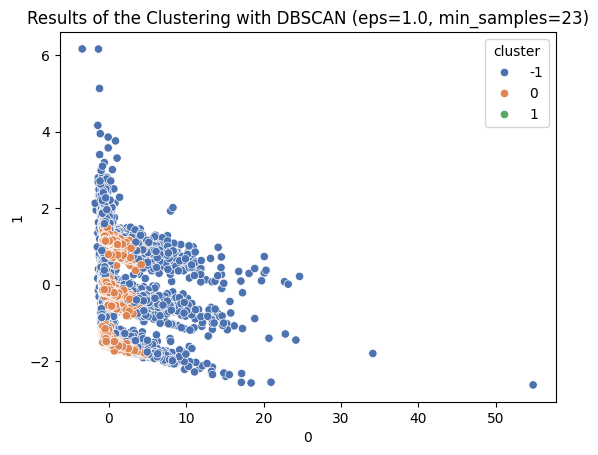

In [ ]:
import seaborn as sns

#Extracting values needed for plotting from best_dict
best_epsilon2 = best_dict2['best_epsilon']
best_min_samples2 = best_dict2['best_min_samples']
best_labels2 = best_dict2['best_labels']

#Adding cluster labels to the original DataFrame
mydata_with_clusters2['cluster'] = best_labels2

#Plot of the final results
sns.scatterplot(x=mydata_with_clusters2.iloc[:, 0], y=mydata_with_clusters2.iloc[:, 1], hue=mydata_with_clusters2['cluster'], palette='deep')
plt.title(f'Results of the Clustering with DBSCAN (eps={best_epsilon2}, min_samples={best_min_samples2})')
plt.show()

We found that the best combination is an epsilon of 1.0 and a number of samples of 23, then we have quite dense clusters. In this case the DBSCAN algorithm has identified three main clusters labeled as Cluster 0 (in orange in the plot), while isolated and less dense points are labeled as noise or outliers. They are the cluster -1 in blu, and these are points that do not belong to any main cluster. Finally the cluster 1 is not really visible because the small points are hidden. The main clusters are in general  contiguous and well-separated.

------------------------------------

### 4. Command Line Question

Here is another command line question to enjoy. We previously stated that using the command line tools is a skill that Data Scientists must master.

In this question, you should use any command line tool that you know to answer the following questions using the same dataset that you have been using so far:
  + What is the most-watched Netflix title?
  + Report the average time between subsequent clicks on Netflix.com
  + Provide the ID of the user that has spent the most time on Netflix
    
__Important note:__ You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable. Please run the script and include a __screenshot__ of the <ins>output</ins> in the notebook for evaluation.  

### To execute the CommandLine.sh script from the notebook use the following command in a cell

In [ ]:
# Run the CommandLine.sh script
!bash CommandLine.sh

Most-watched Netflix title:
Black Mirror: Bandersnatch
Average time between subsequent clicks:
33476.1
User ID that spent the most time on Netflix:
322abe045c


Screenshot of the output of the CommandLine.sh in the Git Bash terminal, saved in the file "SS.png"

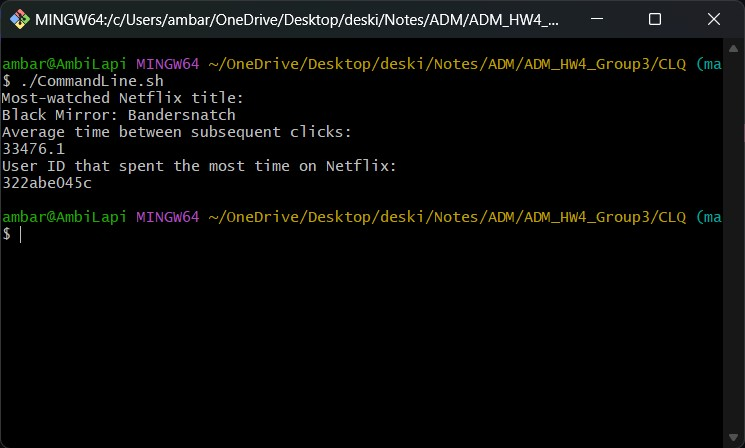

--------------------------------

### 5. Algorithmic Question 

Federico studies in a demanding university where he has to take a certain number $N$ of exams to graduate,  but he is free to choose in which order he will take these exams. Federico is panicking since this university is not only one of the toughest in the world but also one of the weirdest. His final grade won't depend at all on the mark he gets in these courses: there's a precise evaluation system. 

He was given an initial personal score of $S$ when he enrolled, which changes every time he takes an exam: now comes the crazy part.
He soon discovered that every of the $N$ exams he has to take is assigned a mark $p$. Once he has chosen an exam, his score becomes equal to the mark $p$, and at the same time, the scoring system changes:
+ If he takes an "easy" exam (the score of the exam being less than his score), every other exam's mark is increased by the quantity $S - p$.
+ If he takes a "hard" exam (the score of the exam is greater than his score), every other exam's mark is decreased by the quantity $p - S$.
  
So, for example, consider $S=8$ as the initial personal score. Federico must decide which exam he wants to take, being $[5,7,1]$ the marks list. If he takes the first one, being $5 < 8$ and $8 - 5 = 3$, the remaining list now becomes $[10,4]$, and his score is updated as $S = 5$.

In this chaotic university where the only real exam seems to be choosing the best way to take exams, you are the poor student advisor who is facing a long queue of confused people who need some help. Federico is next in line,  and he comes up in turn with an inescapable question: he wants to know which is the highest score possible he could get. 

a) Fortunately, you have a computer app designed by a brilliant student. Federico wants you to show him the code which this app is based on
because he wants to do paid counseling for other desperate students: in a *recursive* fashion, the helped helps the helpable.

b) Federico is getting angry because he claims that your code is slow! Show him formally with a big-O notation that he is as crazy as this university! 

c) If, unfortunately, Federico is right in the grip of madness, he will threaten you to optimize the code through a different approach. 
You should end this theater of the absurd by any means! (And again, formally prove that you improved time complexity)

d) Ask chatGPT for a third (optimized) implementation and analyze again its time complexity. Be careful (and crafty) in defining the prompt, and challenge the machine in this coding question!

Here are some input/output examples (the first value is the initial personal score, and the second line contains the list of marks): 

__Input 1__
```
8
5 7 1 
```

__Output 1__
```
11
```

__Input 2__
```
25
18 24 21 32 27
```

__Output 2__
```
44
```

__Input 3__
```
30
13 27 41 59 28 33 39 19 52 48 55 79
```

__Output 3__
```
205
```


---------------

### a) Recursive Solution

In [ ]:
def max_final_score(S, exams): 
    # Base case: no exams left
    if not exams: 
        # Return the final score
        return S 

    # Initialize the maximum score
    max_score = 0 
    # Iterate over the exams
    for i, p in enumerate(exams): 
        # Copy the list to avoid modifying the original
        next_exams = exams[:i] + exams[i+1:] 
        # Check if the score is less than the threshold
        if p < S: 
            # Increase the marks of remaining exams
            next_exams = [x + (S - p) for x in next_exams] 
        # Check if the score is greater than the threshold
        else: 
            # Decrease the marks of remaining exams
            next_exams = [x - (p - S) for x in next_exams]
        
        # Recursive call for the next exams
        final_score = max_final_score(p, next_exams)
        # Update the maximum score
        max_score = max(max_score, final_score)

    # Return the maximum score
    return max_score 

In [ ]:
# Input
S = int(input()) # Initial score of the student
exams = list(map(int, input().split())) # Scores of the exams

# Output
print(max_final_score(S, exams)) # Maximum final score that can be achieved

44


__Input__
```
25
18 24 21 32 27
```

__Output__
```
44
```

---------------

### b) Time Complexity Analysis

The recursive solution explores all permutations of the exams since it considers every possible exam at each step. The number of operations can thus be represented as:

- At the first level, we have $N$ choices (where $N$ is the total number of exams).
- At the second level, we have $N-1$ choices for each of the $N$ scenarios.
- This pattern continues until we reach the last exam, where we have only 1 choice.

This can be expressed as $N!$ (factorial), which is the product of all positive integers up to $N$:

$$ T(N) = N \cdot (N-1) \cdot (N-2) \cdot \ldots \cdot 2 \cdot 1 = N! $$

Hence, the time complexity for the recursive solution is $O(N!)$.

--------------

### c) Optimization

In [ ]:
def max_final_score_memo(S, exams, memo):
    # Base case: no exams left
    if not exams:
        # Return the final score
        return S

    # Check if the current set of exams is already stored in the memo
    if tuple(exams) in memo:
        # Return the stored maximum final score
        return memo[tuple(exams)]

    # Initialize the maximum score
    max_score = 0
    # Iterate over the exams
    for i, p in enumerate(exams):
        # Copy the list to avoid modifying the original
        next_exams = exams[:i] + exams[i+1:]

        # Check if the score is less than the threshold
        if p < S:
            #  Increase the marks of remaining exams
            next_exams = [x + (S - p) for x in next_exams]
        # Check if the score is greater than the threshold
        else:
            # Decrease the marks of remaining exams
            next_exams = [x - (p - S) for x in next_exams]
        
        # Recursive call for the next exams
        # Pass the memo to avoid recalculation of the same set of exams
        final_score = max_final_score_memo(p, next_exams, memo)
        # Update the maximum score
        max_score = max(max_score, final_score)

    # Store the maximum final score in the memo
    memo[tuple(exams)] = max_score

    # Return the maximum score
    return max_score

In [ ]:
# Input
memo = {} # Memo to store the maximum final score for a set of exams
S = int(input()) # Initial score of the student
exams = list(map(int, input().split())) # Scores of the exams

# Output
print(max_final_score_memo(S, exams, memo)) # Maximum final score that can be achieved

44


__Input__
```
25
18 24 21 32 27
```

__Output__
```
44
```

#### Time Complexity Analysis of Optimization

The memoized version reduces the number of calculations by storing the results of subproblems. Thus, each unique set of exams only needs to be calculated once. However, in the worst case, we still need to calculate the score for every possible subset of exams, which can be represented by the powerset of exams. The size of the powerset of a set with $N$ elements is $2^N$.

But due to the nature of score adjustment, some of the subsets are not independent (since the scores of the remaining exams change based on the current score S), so we cannot directly apply the powerset argument.

Instead, we consider the number of operations for generating each new subset and the number of choices we have at each step. For each choice of exam, we calculate the new scores for the remaining exams, which is an $O(N)$ operation. We do this for each of the $N$ exams, leading to $O(N^2)$ operations for each set of choices.

However, because of memoization, we do not recompute the scores for the same set of remaining exams. Therefore, the total number of operations is bounded by the number of unique subsets we can form, which is less than or equal to the number of permutations, as the order of exams matters in our scenario. Hence, we get a time complexity that is better than $O(N!)$ but not as good as $O(2^N)$.

We can argue that the time complexity is approximately $O(N^2)$, considering that the number of unique subsets we need to compute due to the changing scores is significantly less than the total number of permutations.

-------------------

### d) Third Implementation

#### 1) Iterative Dynamic Programming Approach

An iterative approach can be faster than a recursive approach due to overheads associated with function calls and stack usage in recursion. However, the given problem involves a complex state transition that depends on the ordering of exams, which doesn't easily translate into a typical bottom-up dynamic programming approach.

The primary difficulty lies in the fact that the impact of taking an exam on the remaining exams is not independent of the exams themselves – it's a function of the difference between scores. This interdependency between exams makes a traditional iterative DP approach challenging to formulate.

However, if we could find a way to represent the state of the exams after each choice in a manner that allows us to iteratively build up to the final solution, we could attempt an iterative DP solution. Unfortunately, given the complexity of the state transition, an iterative DP solution is not straightforward and may not be possible without significantly transforming the problem.

Given this complexity, and without a concrete iterative DP solution, I'll move on to providing a heuristic approach.

#### 2) Heuristic or Approximate Solution

Heuristic approaches aim to find a good enough solution within a reasonable timeframe, especially when the optimal solution is computationally infeasible for large inputs. For Federico's problem, one simple heuristic might be to always choose the exam that minimizes the maximum change to other exams' scores.

Here's a simple heuristic in Python:

In [ ]:
def heuristic_max_score(S, exams):
    exams = sorted(exams)
    while exams:
        # Find the exam that is closest to the current score S
        closest_exam = min(exams, key=lambda p: abs(S - p))
        exams.remove(closest_exam)
        if closest_exam < S:
            S = closest_exam
            exams = [x + (S - closest_exam) for x in exams]
        elif closest_exam > S:
            S = closest_exam
            exams = [x - (closest_exam - S) for x in exams]
    return S

In [ ]:
# Input
S = int(input()) # Initial score of the student
exams = list(map(int, input().split())) # Scores of the exams

# Output
print(heuristic_max_score(S, exams)) # Maximum final score that can be achieved

32


__Input__
```
25
18 24 21 32 27
```

__Output__
```
32
```

This heuristic solution simply tries to minimize the impact on the score of the remaining exams by always choosing the exam score that's closest to the current score `S`. However, this does not guarantee an optimal solution, as sometimes taking an exam with a larger difference early on could lead to a better configuration of scores for subsequent exams.

##### Time Complexity Analysis of Heuristic Approach

In the heuristic approach, we perform the following operations:

1. Sort the exams initially, which takes $O(N \log N)$ time.
2. Iterate through the exams, which takes $O(N)$ time.
3. For each exam, we find the closest exam, which, if implemented as a linear search, takes $O(N)$ time.
4. We then adjust the scores of the remaining exams, which also takes $O(N)$ time per exam.

The most expensive operation is finding the closest exam for each of the $N$ exams, resulting in $O(N^2)$ time.

Therefore, the time complexity of the heuristic approach is dominated by the $O(N^2)$ complexity due to steps 3 and 4, even though the initial sorting adds $O(N \log N)$ complexity. Thus, we can express the overall time complexity as $O(N^2)$.

---------------------